# Setup 

## Imports

In [1]:
from vaiutils import path_consts, plot_images, smooth_plot
from os.path import exists
from scipy.misc import imread, imresize
from tqdm import tqdm_notebook
import pickle
import tensorflow as tf

Keras modules

In [2]:
import keras.backend as K
from keras.applications.vgg16 import VGG16
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Input, Lambda, Cropping2D, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.merge import Add
from keras.engine.topology import Layer
from keras.models import Model
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


## Define useful variables and functions

In [3]:
for k, v in path_consts('FastStyleTransfer', ('COCO', 'SampleImages')):
    exec(k + '=v')

A custom Keras Layer for Reflection Padding

In [4]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(40, 40), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, x):
        w_pad, h_pad = self.padding
        return tf.pad(x, ((0, 0), (h_pad, h_pad), (w_pad, w_pad), (0, 0),), 'REFLECT')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] + 2 * self.padding[0], input_shape[2] + 2 * self.padding[1], input_shape[3])

In [5]:
def conv_block(x, num_filters=128, kernel_size=3, strides=1, padding='same', activation='relu', name='conv'):
    if type(strides) is int:
        x = Conv2D(num_filters, kernel_size, strides=(
            strides, strides), padding=padding, name=name)(x)
    else:
        strides = int(1/strides)
        x = UpSampling2D((strides, strides), name=name+'_up')(x)
        x = Conv2D(num_filters, kernel_size, padding='same', name=name)(x)

    x = BatchNormalization(name=name + '_bn')(x)
    return Activation(activation, name=name + '_relu')(x) if activation is not None else x

In [6]:
def res_block(x, block_id=None):
    name = 'res_block'
    if block is not None:
        name += '_' + str(block_id)

    y = conv_block(x, padding='valid', name=name + '_conv1')
    y = conv_block(y, padding='valid', activation=None, name=name + '_conv2')
    return Add(name=name + '_add')([Cropping2D(2, name=name + '_crop')(x), y])

Function returning the Gram matrix of a feature activation

In [7]:
def gram_np(x):
    x = x[0].transpose((2, 0, 1))
    s = x.shape
    x = x.reshape((x.shape[0], -1))
    return np.expand_dims(x.dot(x.T), 0) / np.prod(s)

In [8]:
def gram(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))) / K.prod(K.cast(s[1:], K.floatx()))

# Create Models

## Stylizer Model

In [9]:
def get_model():
    K.clear_session()

    img_input = Input(shape=(256, 256, 3), name='img_input')
    x = ReflectionPadding2D(name='reflect')(img_input)
    x = conv_block(x, 32, 9, name='conv1')
    x = conv_block(x, 64, strides=2, name='conv2')
    x = conv_block(x, strides=2, name='conv3')
    for i in range(5):
        x = res_block(x, i + 1)
    x = conv_block(x, 64, strides=1 / 2, name='tconv1')
    x = conv_block(x, 32, strides=1 / 2, name='tconv2')
    x = conv_block(x, 3, activation='tanh', name='conv4')
    x = Lambda(lambda x: (x + 1) * 127.5)(x)

    model = Model(img_input, x)
    return model

In [10]:
model = get_model()
model.summary(150)

______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
img_input (InputLayer)                           (None, 256, 256, 3)              0                                                                   
______________________________________________________________________________________________________________________________________________________
reflect (ReflectionPadding2D)                    (None, 336, 336, 3)              0                 img_input[0][0]                                   
______________________________________________________________________________________________________________________________________________________
conv1 (Conv2D)                                   (None, 336, 336, 32)             7808        

## VGG Model

In [12]:
vgg_mean = np.array([123.68, 116.779, 103.939])


def preprocess_input(x): return (x - vgg_mean)[:, :, :, ::-1]

In [13]:
vgg = VGG16(include_top=False, input_tensor=Lambda(
    preprocess_input)(Input((256, 256, 3))))
vgg = Model(vgg.input, [vgg.get_layer(
    'block{}_conv2'.format(str(i))).output for i in range(2, 6)])
for layer in vgg.layers:
    layer.trainable = False
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
__________

## Get the style features from the VGG Network

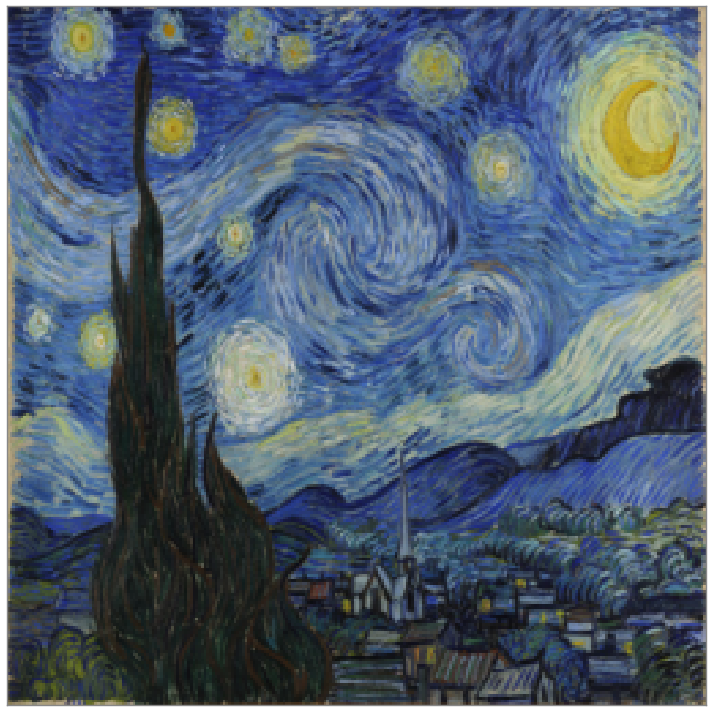

In [17]:
style_image = imresize(
    imread(DIR_DATA['SampleImages'] + '/starry-night.jpg'), (256, 256))
plot_images([style_image])

In [18]:
style_feat_maps = vgg.predict(np.expand_dims(style_image, 0))

In [19]:
style_gram_maps = [gram_np(f) for f in style_feat_maps]

## Custom Loss Model

In [20]:
content_input = Input((256,256,3), name='content_input')
transformed_output = model(content_input)

content_activations = vgg(content_input)
pred_activations = vgg(transformed_output)

pred_gram_maps = [Lambda(gram, name='gram'+str(i+2))(f) for i, f in enumerate(pred_activations)]

activation_importance=[0.1, 0.2, 0.1, 0.6]
loss_importance=[1, 0.5, 1e-6]
def content_loss(activation_list):
    x_list = activation_list[:4]
    y_list = activation_list[4:]
    loss = 0

    for x, y, w in zip(x_list, y_list, activation_importance):
        diff = x - y
        dims = list(range(1, K.ndim(diff)))
        loss += K.expand_dims(K.sqrt(K.mean(diff**2, dims))) * w
    return loss * loss_importance[0]

def style_loss(activation_list):
    loss = 0

    for activation, gram_style in zip(activation_list, style_gram_maps):
        diff = activation - gram_style
        dims = list(range(1, K.ndim(diff)))
        loss += K.expand_dims(K.sqrt(K.mean(diff**2, dims)))
    return loss * loss_importance[1]

def tv_loss(x):
    a = K.square(x[:, :255, :255, :] - x[:, 1:, :255, :])
    b = K.square(x[:, :255, :255, :] - x[:, :255, 1:, :])
    return K.sum(K.pow(a + b, 1.25), axis=[1, 2, 3]) * loss_importance[2]


content_loss = Lambda(content_loss, name='content_loss')(
    content_activations + pred_activations)
style_loss = Lambda(style_loss, name='style_loss')(pred_gram_maps)
variation_loss = Lambda(tv_loss, name='variation_loss')(transformed_output)
loss_output = Add()([content_loss, style_loss, variation_loss])

trainer_net = Model(content_input, loss_output)
trainer_net.compile('adam', 'mae')
trainer_net.summary(120)

________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
content_input (InputLayer)             (None, 256, 256, 3)        0                                                     
________________________________________________________________________________________________________________________
model_1 (Model)                        (None, 256, 256, 3)        1675535       content_input[0][0]                     
________________________________________________________________________________________________________________________
model_2 (Model)                        [(None, 128, 128, 128), (N 12354880      content_input[0][0]                     
                                                                                model_1[1][0]                           
________________________________

# Load Dataset

In [21]:
generator = ImageDataGenerator()
content_data = generator.flow_from_directory(DIR_DATA['COCO'], batch_size=4)
content_data.batches_per_epoch = int(content_data.samples / content_data.batch_size)

Found 5000 images belonging to 1 classes.


# Train model

In [22]:
if exists(DIR_OUTPUT+'/history.dat'):
    with open(DIR_OUTPUT+'/history.dat', 'rb') as f:
        history = pickle.load(f)
else:
    history = {}
    
if exists(DIR_OUTPUT+'/weights.h5'):
        model.load_weights(DIR_OUTPUT+'/weights.h5')

In [31]:
def fit_trainer(epochs=1, lr=1e-3):
    if epochs > 1:
        for _ in tqdm_notebook(range(epochs)):
            fit_trainer(lr=lr)
        return
        
    global history
    
    trainer_net.optimizer.lr=lr
    
    if exists(DIR_OUTPUT+'/weights.h5'):
        model.load_weights(DIR_OUTPUT+'/weights.h5')
    
    hist = trainer_net.fit_generator(content_data, content_data.batches_per_epoch, epochs=epochs,verbose=0,callbacks=[TQDMNotebookCallback()])
    
    model.save_weights(DIR_OUTPUT+'/weights.h5')
    
    for k, v in hist.history.items():
        if k not in history.keys():
            history[k] = []
        history[k] += hist.history[k]
    
    with open(DIR_OUTPUT+'/history.dat', 'wb') as f:
        pickle.dump(history, f)

In [24]:
model.save_weights(DIR_OUTPUT+'/weights.h5')

In [80]:
fit_trainer(2, 1e-3)

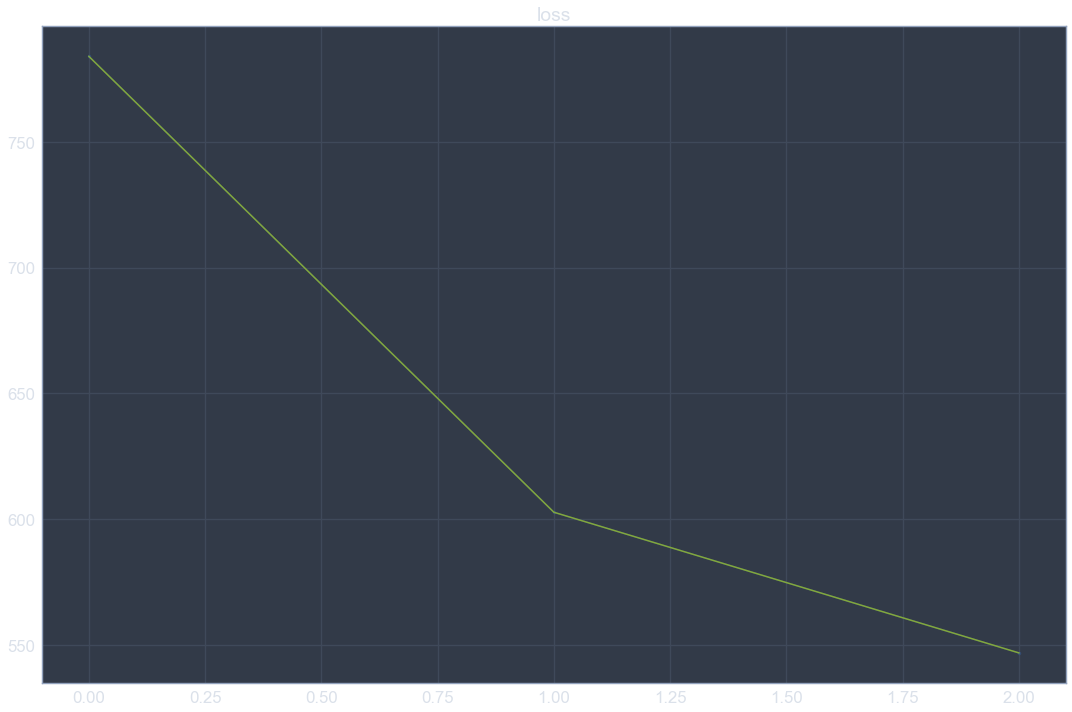

In [90]:
smooth_plot(history, remove_outlier=False)

# Test Model

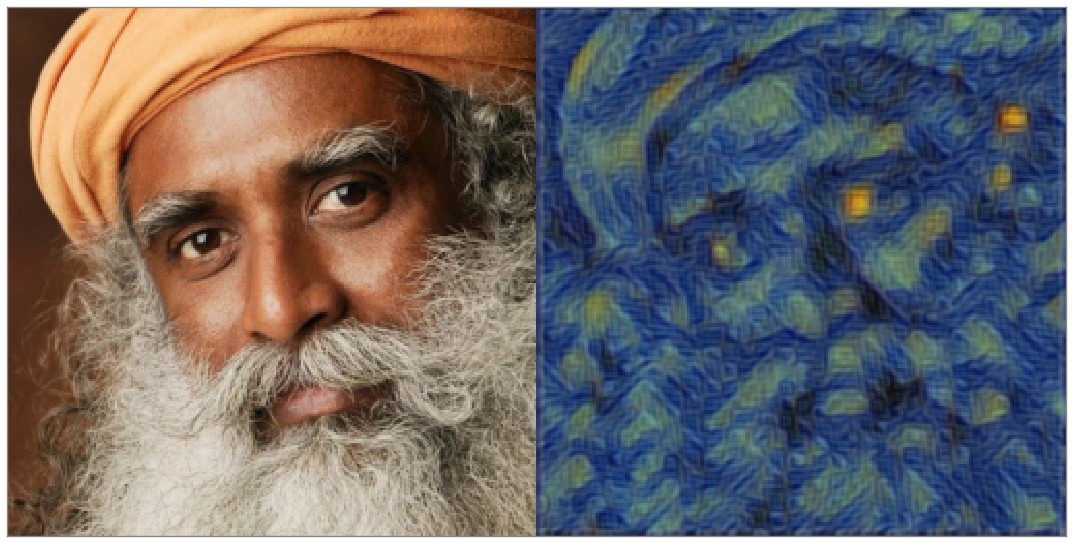

In [23]:
content_image = imresize(
    imread(DIR_DATA['SampleImages'] + '/sadhguru.jpg'), (256, 256))

sample_style = model.predict(np.expand_dims(content_image, 0))[0]

plot_images([content_image, sample_style])